### seq2seq with teacher forcing

In [1]:
import os
import pandas as pd             #데이터를 Dataframe으로 다루는 라이브러리
from pandas import DataFrame
import numpy as np              #데이터를 행열 또는 array 형태로 다루는 라이브러리
import random

from time import time
from datetime import datetime
import math
from copy import deepcopy

import matplotlib.pyplot as plt #데이터를 그래프 plot으로 보여주는 라이브러리
import seaborn as sns

import requests                 #네트워크 접근 라이브러리
from bs4 import BeautifulSoup   #웹사이트 접근하는 라이브러리

from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
torch.manual_seed(77)

from torch import nn as nn
from torch import optim
from torch.nn import functional as F
from torch import tensor

from torchsummary import summary

import warnings
warnings.filterwarnings('ignore')

In [ ]:

target = '삼성전자'

# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와
# 네이버 금융(http://finance.naver.com)에 넣어줌

code_krx = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', encoding='cp949', header=0)[0]
# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌
code_krx


In [ ]:
code_krx.종목코드 = code_krx.종목코드.map('{:06d}'.format)
# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다.
code_krx = code_krx[['회사명', '종목코드']]
# code_krx
target_code = code_krx[code_krx['회사명']==target]
target_code

In [ ]:
# 종목코드로 네이버에서 종목 주소 생성 확인
def get_url(code): #(item_name, code_df):
    url = 'https://finance.naver.com/item/sise_day.naver?code='+'{code}'.format(code=code).lstrip()
    return url
code = target_code['종목코드'].iloc[0]
url = get_url(code)
url

In [ ]:
# 위에서 찾은 네이버 타겟종목 페이지에서 마지막 페이지 크기 확인
url_page = url + '&page=1'
headers = {'User-agent':'Mozilla/5.0'}
html = requests.get(url_page, headers=headers).text
soup = BeautifulSoup(html,"html.parser")
tags = soup.find_all('a')
# print(tags[11]["href"])
last_page = tags[11]["href"]
last_page = last_page.split('=')[2]
last_page
# print(f"target_code :회사명 == [{target_code['회사명'].iloc[0]}] 종목코드 == [{target_code['종목코드'].iloc[0]}] 마지막 페이지 == [{last_page}]")

In [ ]:
last_page = int(155) # 임시 150 페이지 까지만

# 일 데이터를 담을 df_code라는 DataFrame 정의
df_code = pd.DataFrame()
url.lstrip()
for page in range(1,int(last_page)+1):
    # pg_url = ('{url}&page={page}'.format(url=url, page=page)).lstrip()
    # pg = pd.read_html(pg_url,encoding='euc-kr',header=1)[0]
    # df_code = pd.concat([df_code,pg])
    req = requests.get(f'{url}&page={page}',headers=headers)
    df_code = pd.concat([df_code,pd.read_html(req.text,encoding='euc-kr')[0]],ignore_index=True)

# df.dropna()를 이용해 결측값 있는 행 제거
df_code = df_code.dropna()
df_code.reset_index(drop=True, inplace=True)

# 상위 15개 데이터 확인하기
df_code.head(15)

In [ ]:
# 한글로 된 컬럼명을 영어로 바꿔줌
stock_data = df_code.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'})
stock_data['diff'] = stock_data['diff'].str.replace('상승','').str.replace('하락','').str.replace('보합','').str.replace(',','').str.replace(' ','').str.strip()
# 데이터의 타입을 int형으로 바꿔줌
stock_data[['close', 'diff', 'open', 'high', 'low', 'volume']] = stock_data[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(float)
# 컬럼명 'date'의 타입을 date로 바꿔줌
stock_data['date'] = pd.to_datetime(stock_data['date'])
# 일자(date)를 기준으로  정렬
stock_data = stock_data.sort_values(by=['date'],ascending = True)
# 상위 5개 데이터 확인
print(stock_data.shape)
stock_data.reset_index(drop=True, inplace=True)
stock_data.head(15)

In [ ]:
df = stock_data.copy()
df = df.set_index('date')
df

In [ ]:
df.plot(subplots=True, figsize=(15,15))

### 데이터 세이브와 로드
- 매번 새롭게 데이터를 받는 것이 문제가 될 수 있기 때문에 데이터를 저장하고 재사용하도록 읽는 코드 추가

In [2]:
target = "삼성전자"
code = "005930"

# data save
path = "./data/stock/"
# if not os.path.exists(path):
#     os.mkdir(path)
filename = "005930.csv"
# df.to_csv(os.path.join(path,filename), index=True)

In [3]:
# load data
df = pd.read_csv(os.path.join(path,filename), index_col='date')
df.head()


,close,diff,open,high,low,volume
date,,,,,,
2019-02-18,46200.0,150.0,46500.0,46850.0,45850.0,8183728.0
2019-02-19,45950.0,250.0,45850.0,46150.0,45450.0,6741395.0
2019-02-20,46900.0,950.0,46750.0,47100.0,46500.0,11506720.0
2019-02-21,46950.0,50.0,46500.0,47200.0,46200.0,8694009.0
2019-02-22,47150.0,200.0,46500.0,47150.0,46450.0,6895772.0


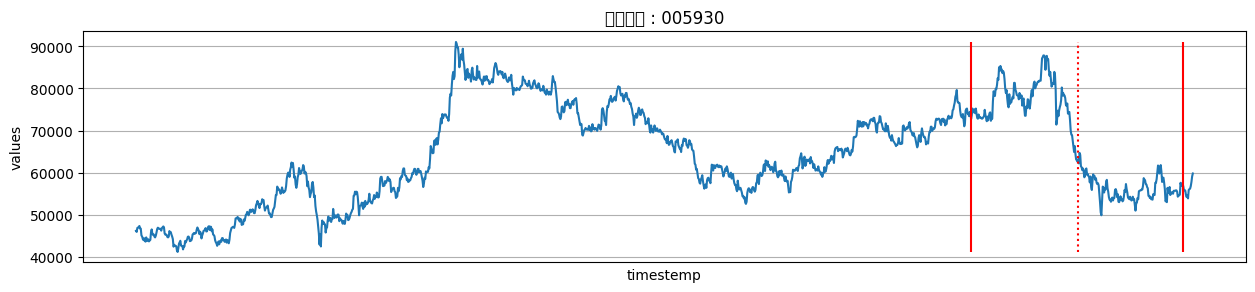

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,3))
ax.plot(df['close'])
ax.vlines(df[df.index == df.iloc[round(len(df)*0.79)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= '-')
ax.vlines(df[df.index == df.iloc[round(len(df)*0.89)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= ':')
ax.vlines(df[df.index == df.iloc[round(len(df)*0.99)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= '-')
ax.set_title(target + ' : ' + code)
ax.set_xlabel('timestemp')
ax.set_xticks(df.index[::15])
ax.set_xticklabels(df.index[::15])
ax.tick_params(axis='x', rotation=90, labelcolor="blue")
plt.rc('xtick', labelsize=5)
ax.set_ylabel('values')
ax.grid()
fig.tight_layout
plt.show()

In [35]:
# 데이터를 훈련, 검증, 테스트로 나눈다.
df_train = df.iloc[:round(len(df)*0.8)]
df_valid = df.iloc[round(len(df)*0.8):round(len(df)*0.9)]
df_test = df.iloc[round(len(df)*0.9):len(df)]

print(f" df.shape 0.8 : {round(df.shape[0]*0.8)}")
print(f" df_train.shape : {df_train.shape}")
print(f" df_valid.shape : {df_valid.shape}")
print(f" df_test.shape : {df_test.shape}")
# print(f" check {(round(df.shape[0]*0.7)) == df_train.shape[0]+df_valid.shape[0]+df_test.shape[0]}")

 df.shape 0.8 : 1240
 df_train.shape : (1240, 6)
 df_valid.shape : (155, 6)
 df_test.shape : (155, 6)


In [36]:
scaler = StandardScaler()
scaler.fit(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df.columns)
df_valid_scaled = pd.DataFrame(scaler.transform(df_valid),columns=df.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df.columns)

In [37]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5, predict_length=1):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.predict_length = predict_length
        # self.y = torch.tensor(dataframe[target].values).float()
        self.y = torch.tensor(dataframe[features].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        self.datetime = dataframe.index 

    def __len__(self):
        return len(self.X) - (self.sequence_length + self.predict_length)
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.sequence_length
        seq_x = self.X[s_begin:s_end]
        r_begin = s_end #- self.predict_length
        r_end = r_begin + self.predict_length
        seq_y = self.y[r_begin :r_end]
        return seq_x, seq_y

 # start point padding type
    # def __len__(self):
    #     return self.X.shape[0]

    # def __getitem__(self, i): 
    #     if i >= self.sequence_length - 1:
    #         i_start = i - self.sequence_length + 1
    #         x = self.X[i_start:(i + 1), :]
    #     else:
    #         padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
    #         x = self.X[0:(i + 1), :]
    #         x = torch.cat((padding, x), 0)

        # return x, self.y[i]

In [38]:
target='close'
features= df.columns
sequence_length = 25
predict_length = 7

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

i = 27
X, y = train_dataset[i]
print(X)
print(y)

tensor([[-1.5932, -0.3363, -1.5849, -1.6024, -1.5995, -1.1612],
        [-1.6101, -0.8034, -1.6228, -1.6276, -1.6080, -0.5749],
        [-1.5763, -0.4920, -1.5638, -1.5815, -1.5529, -1.0933],
        [-1.5171, -0.0249, -1.5343, -1.5269, -1.5104, -0.8274],
        [-1.4452,  0.2086, -1.4330, -1.4723, -1.4723, -0.4563],
        [-1.4156, -0.5698, -1.4837, -1.4430, -1.4426, -0.4295],
        [-1.4241, -0.9591, -1.4162, -1.4052, -1.4044, -0.9447],
        [-1.4410, -0.8034, -1.3909, -1.4304, -1.4426, -0.9495],
        [-1.4410, -1.1148, -1.4373, -1.4555, -1.4383, -1.1540],
        [-1.4368, -1.0369, -1.4626, -1.4765, -1.4511, -0.5257],
        [-1.4748, -0.4142, -1.4373, -1.4681, -1.4426, -0.2981],
        [-1.4241, -0.1806, -1.4921, -1.4597, -1.4553, -1.0548],
        [-1.4072, -0.8034, -1.3993, -1.4094, -1.3704, -0.9212],
        [-1.3903, -0.8034, -1.3782, -1.4178, -1.3874, -1.0470],
        [-1.4072, -0.8034, -1.3867, -1.4010, -1.3704, -1.3253],
        [-1.5298,  1.1428, -1.3951, -1.4

In [39]:
X, y = train_dataset[i+1]
print(X)
print(y)

tensor([[-1.6101, -0.8034, -1.6228, -1.6276, -1.6080, -0.5749],
        [-1.5763, -0.4920, -1.5638, -1.5815, -1.5529, -1.0933],
        [-1.5171, -0.0249, -1.5343, -1.5269, -1.5104, -0.8274],
        [-1.4452,  0.2086, -1.4330, -1.4723, -1.4723, -0.4563],
        [-1.4156, -0.5698, -1.4837, -1.4430, -1.4426, -0.4295],
        [-1.4241, -0.9591, -1.4162, -1.4052, -1.4044, -0.9447],
        [-1.4410, -0.8034, -1.3909, -1.4304, -1.4426, -0.9495],
        [-1.4410, -1.1148, -1.4373, -1.4555, -1.4383, -1.1540],
        [-1.4368, -1.0369, -1.4626, -1.4765, -1.4511, -0.5257],
        [-1.4748, -0.4142, -1.4373, -1.4681, -1.4426, -0.2981],
        [-1.4241, -0.1806, -1.4921, -1.4597, -1.4553, -1.0548],
        [-1.4072, -0.8034, -1.3993, -1.4094, -1.3704, -0.9212],
        [-1.3903, -0.8034, -1.3782, -1.4178, -1.3874, -1.0470],
        [-1.4072, -0.8034, -1.3867, -1.4010, -1.3704, -1.3253],
        [-1.5298,  1.1428, -1.3951, -1.4304, -1.4977, -0.4096],
        [-1.5551, -0.6477, -1.5174, -1.5

In [40]:
target = 'close'
features = df_train_scaled.columns
batch_size = 30
sequence_length = 28
predict_length = 7

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
valid_dataset = SequenceDataset(
    df_valid_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
test_dataset = SequenceDataset(
    df_test_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)#, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)#, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)#,collate_fn=my_collate_fn)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([30, 28, 6])
Target shape: torch.Size([30, 7, 6])


In [41]:
class Encoder(nn.Module):
    def __init__(self, 
                 num_features, 
                 hidden_units,
                 predict_length, 
                 bias=True, 
                 num_layers=5, 
                 drop_ratio=0.2,
                 bi_dir=False,
                 device='cpu'):
        super().__init__()
        self.num_features = num_features  
        self.hidden_units = hidden_units
        self.bias = bias
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.bi_dir = bi_dir
        self.device = device

        self.vInput = nn.Linear(in_features=self.num_features, out_features=hidden_units, bias=bias)

        self.lstm = nn.LSTM(
            input_size=hidden_units,
            hidden_size=hidden_units,
            bias=bias,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=drop_ratio,
            bidirectional=bi_dir
        )

    def forward(self, x, y):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)

        x = self.vInput(x)
        last_step = x[:,-1,:]

        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))

        decoder_inputs = self.vInput(y)
        # 이후 이부분을 변경하여 별도 상황에 대한 벡터화 가능할 지도?
        
        return last_step, out, (hidden_state, cell_state), decoder_inputs

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 num_features, 
                 hidden_units,
                 predict_length, 
                 bias=True, 
                 num_layers=5, 
                 drop_ratio=0.2,
                 bi_dir=False,
                 device='cpu'):
        super().__init__()
        self.num_features = num_features  
        self.hidden_units = hidden_units
        self.bias = bias
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.bi_dir = bi_dir
        self.device = device

        self.lstm = nn.LSTM(
            input_size=hidden_units,
            hidden_size=hidden_units,
            bias=bias,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=drop_ratio,
            bidirectional=bi_dir
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1, bias=bias)

    def forward(self, initial_input, encoder_outputs, hidden, targets, decoder_inputs,
                teacher_force_probability):

        decoder_sequence_length = targets.shape[1]
        seqOuts = torch.full_like(targets, 0).to(self.device)
        input_at_t = initial_input.unsqueeze(1)

        for t in range(decoder_sequence_length):
            output, hidden = self.lstm(input_at_t, hidden)
            seqOuts[:,t,0]  = self.linear(output).squeeze()
            # 현재는 타겟에 대한 sequence 만 예측하도록 되어 있는 infer linear 임.

            # Set-up input for next timestep
            teacher_force = random.random() < teacher_force_probability
            input_at_t = decoder_inputs[:,t].unsqueeze(1) if teacher_force else output

        return seqOuts


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_inputs, targets, teacher_force_probability):
        lastStep, encoder_outputs, hidden, decoder_inputs = self.encoder(encoder_inputs, targets)

        outputs = self.decoder(lastStep, encoder_outputs,
                               hidden, targets, decoder_inputs, teacher_force_probability)
        return outputs

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f" 🤗 is_available device : \n\t{device}")

epochs = 300

learning_rate = 0.003
num_hidden_units = 512
# hidden_size = 256
teacher_force_probability = 0.3

seq2seq = Seq2Seq(
                    Encoder(
                            num_features = len(features), 
                            hidden_units = num_hidden_units,
                            predict_length = predict_length, 
                            bias=True, 
                            num_layers=5, 
                            drop_ratio=0.0,
                            bi_dir=False,
                            device=device), 
                    Decoder(
                            num_features = len(features), 
                            hidden_units = num_hidden_units,
                            predict_length = predict_length, 
                            bias=True, 
                            num_layers=5, 
                            drop_ratio=0.0,
                            bi_dir=False,
                            device=device),
                )

loss_function = nn.MSELoss()
# loss_function = nn.L1Loss()

optimizer = torch.optim.Adam(seq2seq.parameters(), lr=learning_rate)

print(f"\n 🤩 loss_function : \n\t{loss_function}\n")
print(f" 🤓 optimizer : \n\t{optimizer}")

# summary(model=seq2seq, input_size=(28,6))


 🤗 is_available device : 
	cuda

 🤩 loss_function : 
	MSELoss()

 🤓 optimizer : 
	Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.003
    maximize: False
    weight_decay: 0
)


In [58]:
def train_model(data_loader, model, loss_function, optimizer, device, teacher_force_probability):
    num_batches = len(data_loader)
    total_loss = 0
    model.to(device)
    
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X,y,teacher_force_probability)
        loss = loss_function(output[:,:,0], y[:,:,0])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def eval_model(data_loader, model, loss_function, device):
    num_batches = len(data_loader)
    total_loss = 0
    
    model.to(device)

    teacher_force_probability = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X, y, teacher_force_probability)
            total_loss += loss_function(output[:,:,0], y[:,:,0]).item()

    avg_loss = total_loss / num_batches
    print(f"eval loss: {avg_loss}")
    return avg_loss


def infer_model(data_loader, model, device):
    num_batches = len(data_loader)
    total_loss = 0
    predict = []
    label = []
    model.to(device)

    teacher_force_probability = 0.0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X, y, teacher_force_probability)
            pred = output[:,:,0].to('cpu').numpy()
            np.squeeze(pred)
            predict.append(list(pred[0]))
            true = y.to('cpu').numpy()
            np.squeeze(true)
            label.append(list(true[0]))
        
    return predict, label


In [59]:
print("Untrained evaluate\n--------")
eval_model(valid_loader, seq2seq, loss_function, device)
print()

epoch = []
train_loss_list = []
eval_loss_list = []

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, seq2seq, loss_function, optimizer, device, teacher_force_probability)
    eval_loss = eval_model(valid_loader, seq2seq, loss_function, device)
    print()
    epoch.append(ix_epoch+1)
    train_loss_list.append(train_loss)
    eval_loss_list.append(eval_loss)
result = pd.DataFrame({'epoch':epoch, 'train_loss':train_loss_list, 'eval':eval_loss_list})
result

Untrained evaluate
--------
eval loss: 1.5200780779123306

Epoch 0
---------
Train loss: 1.9548471396323293
eval loss: 0.7719230726361275

Epoch 1
---------
Train loss: 1.3224423459614627
eval loss: 1.1793852150440216

Epoch 2
---------
Train loss: 1.0699077973375097
eval loss: 1.3411861583590508

Epoch 3
---------
Train loss: 1.0138039443641902
eval loss: 1.3742685467004776

Epoch 4
---------
Train loss: 0.9999836674891412
eval loss: 1.4065936505794525

Epoch 5
---------
Train loss: 0.9581547465175391
eval loss: 1.1392821744084358

Epoch 6
---------
Train loss: 0.6574521677335724
eval loss: 0.30836666747927666

Epoch 7
---------
Train loss: 0.4505677163600922
eval loss: 0.5513474196195602

Epoch 8
---------
Train loss: 0.4624736888334155
eval loss: 0.36098064109683037

Epoch 9
---------
Train loss: 0.48629704834893345
eval loss: 1.2694442495703697

Epoch 10
---------
Train loss: 0.7363637099973858
eval loss: 1.3099555969238281

Epoch 11
---------
Train loss: 0.3912740034982562
eval lo

,epoch,train_loss,eval
0,1,1.954847,0.771923
1,2,1.322442,1.179385
2,3,1.069908,1.341186
3,4,1.013804,1.374269
4,5,0.999984,1.406594
...,...,...,...
295,296,0.039978,0.118967
296,297,0.046938,0.187510
297,298,0.092205,0.124677
298,299,0.049799,0.133939


In [60]:
result = pd.DataFrame({'epoch':epoch, 'train_loss':train_loss_list, 'eval':eval_loss_list})
result

,epoch,train_loss,eval
0,1,1.954847,0.771923
1,2,1.322442,1.179385
2,3,1.069908,1.341186
3,4,1.013804,1.374269
4,5,0.999984,1.406594
...,...,...,...
295,296,0.039978,0.118967
296,297,0.046938,0.187510
297,298,0.092205,0.124677
298,299,0.049799,0.133939


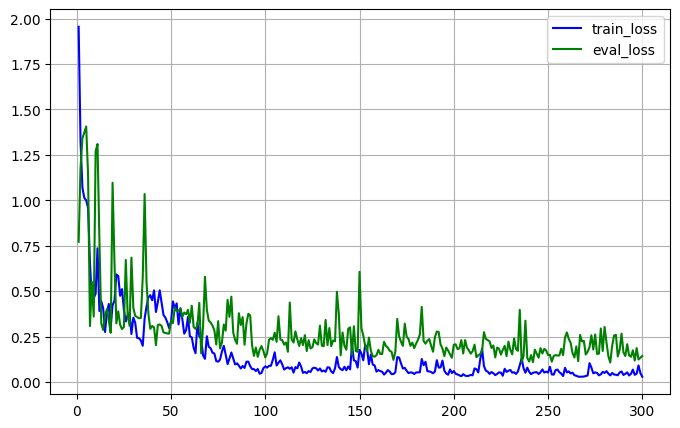

In [61]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(result['epoch'],result['train_loss'], color='blue', label='train_loss')
ax.plot(result['epoch'],result['eval'], color='green', label='eval_loss')
ax.legend()
ax.grid()
plt.show()

In [62]:
# 모델 세이브
savepath = "/home/augustine77/mylab/sim/sim/02_DLnote/results/"
filename = f"{str(sequence_length)}_{str(predict_length)}_{str(learning_rate)}_{str(batch_size)}_tf.pth"
PATH = os.path.join(savepath,filename)
torch.save(seq2seq.state_dict(), PATH)

In [ ]:
# 모델 로드
# seq2seq.load_state_dict(torch.load(PATH))

In [63]:
pred, gt = infer_model(test_loader, seq2seq, device)

In [75]:
aPred = np.array(pred)
aGt = np.array(gt)[:,:,0]

print(aPred.shape)
print(aGt.shape)

(120, 7)
(120, 7)


In [77]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

rmse = root_mean_squared_error(aPred, aGt)
mae = mean_absolute_error(aPred, aGt)
mape = mean_absolute_percentage_error(aPred, aGt)

print(f"forecasting Matrix")
print(f"RMSE : {rmse}")
print(f"MAE  : {mae}")
print(f"MAPE : {mape}")

forecasting Matrix
RMSE : 0.21743114292621613
MAE  : 0.17506711184978485
MAPE : 0.4568479061126709
